# Movie Genre Prediction by Poster
The goal of this notebook is to try to predict a movie's genre by looking at the poster it has.
To achieve this goal I will:
1. Use [The Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) to get 45k movie titles.
2. Use the [omdb_api](http://www.omdbapi.com/) to get the posters for the movies and store them localy.
3. Use Tensorflow and Keras to create a ConvNet that will classify the images.

## Project Structure
1. Data loading, acquisition and cleaning
2. Model creation.
3. Model evaluation.

In [1]:
# Library Loading
import json
from urllib.parse import urlencode
import requests
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

# Loading the 
OMDB_KEY = json.loads(open('apikeys/apikey.json').read())['key']

## 1. Data loading, acquisition and cleaning

### 1.1 Loading 'The Movies' dataset.

In [2]:
the_movies = pd.read_csv('./datasets/The_Movies/movies_metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1.2 Defining the API functions

In [3]:
def get_movie(imdbid):
    '''Gets the movie by imdb id and returns json with the title, genre and imdb id.
       Input args:
       - imdbid: the imdb id of the character
       Returns:
       - If the API responds succesfully return the genres, otherwise return NA
    - 
    '''
    url = 'http://www.omdbapi.com/?apikey=' + OMDB_KEY + '&i=' + str(imdbid)
    r = requests.get(url)
    if r.status_code == 200:
        movie_json = r.json()
        return movie_json['Genre']
    else:
        return 'NA'

def get_poster(imdb_id, path, genre, dataset_type, image_heigth, item_id):
    '''Gets the movie poster as a jpg and saves it to the path.
       Input args:
       - imbd_id: the imdb id of the movie,
       - path: where the dataset will be stored,
       - genre: the genre of the movie,
       - dataset_type: whether we are creating the training or testing,
       - image_height: the height of the poster - api query
       - item_id: identifier to attach to the filename
       Returns:
       - None
    '''
    # construct the requests url
    url = 'http://img.omdbapi.com/?apikey=' + OMDB_KEY + '&i=' + str(imdb_id) + '&h=' + str(image_heigth)
    # create the dir where we store the posters based on the genre and the dataset type
    path = os.path.join(os.getcwd(), path, dataset_type, genre + '/')
    # check if the folder is already_created
    if not os.path.exists(path):
        os.makedirs(path)
    r = requests.get(url)
    filename = os.path.join(os.getcwd(), path, genre + '.' + str(item_id) + '.jpg')
    if r.status_code == 200:
        with open(filename, 'wb') as w:
            w.write(r.content)

### 1.3 Downloading the movie posters.

As a movie can have multiple genres I will make an assumption here - if a genre is listed first - that will be the genre of the movie. Let's create a function that will get only the main genre of the movie from the dataset. If it doesn't find one - download it straight from imdb.

In [4]:
import ast

def get_main_genre(dataset_genre, imdb_id):
    '''
        Gets the main genre of the movie. If there is none listed - pull one directly from imdb.
        Input args:
        - genre_row: the dataset value of the genres for the movie,
        - imdb_id: the imdb_id of the movie
        Returns:
        - main_genre: the main genre of the movie 
    '''
    dataset_genre = ast.literal_eval(dataset_genre)
    if len(dataset_genre) == 0:
        try: 
            main_genre = get_movie(imdb_id).replace(' ', '').split(',')[0]
        except KeyError:
            main_genre = 'NA'
    else:
        main_genre = dataset_genre[0]['name']
        if main_genre == 'N/A':
            main_genre = 'NA'
    return main_genre

In [157]:
# DANGER: Slow Code!
the_movies['main_genre'] = the_movies.apply(lambda x: get_main_genre(x['genres'], x['imdb_id']), axis=1)

In [158]:
the_movies['main_genre'].unique().shape 

(31,)

In [189]:
# quick fix for N/As
the_movies[the_movies['main_genre'] == 'N/A'] = 'NA'

All in all we got 31 classes. Let's create the train - test split now, as we will need it for movie poster download.

In [191]:
from sklearn.model_selection import train_test_split

movies_train, movies_test = train_test_split(the_movies, test_size=0.3, random_state=0)

Finally downloading the movies

In [ ]:
# downloading the posters for the train set
for idx, row in movies_train.iterrows():
    # get_poster(imdb_id, path, genre, dateset_type, image_heigth, item_id):
    get_poster(row['imdb_id'], 'datasets/The_Movies/posters', row['main_genre'], 'train', 600, idx)
# downloading the posters for the test set
for idx, row in movies_test.iterrows():
    get_poster(row['imdb_id'], 'datasets/The_Movies/posters', row['main_genre'], 'test', 600, idx)

The code above has been moved to a script so it can stay overnight and download all of the movies' posters. 
Since that has been done lets move on to what genres we have actually downloaded.

In [3]:
os.listdir('/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/train')

['Fantasy',
 'Drama',
 'Biography',
 'Animation',
 'Science Fiction',
 'Romance',
 'Crime',
 'Adventure',
 'History',
 'War',
 'Foreign',
 'Documentary',
 'Thriller',
 'Music',
 'Action',
 'Western',
 'Short',
 'Family',
 'Horror',
 'Comedy',
 'Mystery',
 'Musical',
 'TV Movie']

From the list, displayed above we can see somethings we can edit/remove. For example 
- Sci-Fi and Science Fiction are the same thing so both dirs can be merged to a common category 'Sci-Fi'
- 'Aniplex', 'Odyssey Media' and 'Carousel Productions' are actually names of companies. Will see how much samples they contribute and if it is not significant (~100 or more)they will be deleted.
- NA - The same treatment - check the number of samples and delete them.

#### Results
- Sci-Fi - it seems that there are only 5 posters in Sci-Fi - thus I can merge it into 'Science Fiction'
- 'Odyssey Media' and 'Carousel Productions' and 'NA' contained no information whatsover.
- 'Removed also 'Adult' as it contained no posters.

#### Aditional Checks performed
- Whether both dirs contain the same genres and the same number of genres.

## 2. Model creation.

### 2.1 Importing the neccesarry libraries.

In [2]:
# Importing the libraries
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### 2.2  Loading the data.
With the help of Keras that should be quite straightforward. The ImageDataGenerator can be used to load the data and get the labels simultaneously in a neat 2D one-hot encoded format. In addition it allows us to generate additional train/validation/test data.

In [5]:
train_location = '/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/train'
test_location = '/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/test'
validation_location = '/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/validation'

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

# The generators
train_generator = train_datagen.flow_from_directory(
    train_location,
    target_size = (300, 300),
    color_mode = 'rgb',
    batch_size = 16,
    class_mode = 'categorical',
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    test_location,
    target_size = (300, 300),
    color_mode = 'rgb',
    batch_size = 16,
    class_mode = 'categorical',
    seed = 42
)

validation_generator = test_datagen.flow_from_directory(
    validation_location,
    target_size = (300, 300),
    color_mode = 'rgb',
    batch_size = 16,
    class_mode = 'categorical',
    seed = 42
)

Found 23273 images belonging to 23 classes.
Found 12494 images belonging to 23 classes.
Found 5832 images belonging to 23 classes.


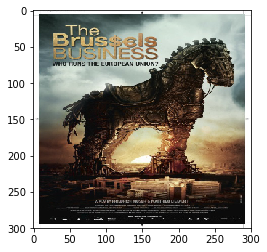

In [6]:
# Show one of the images
x, y = validation_generator.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

### 2.3 Model Building

In [5]:
# Le model
classifier = Sequential()
classifier.add(Conv2D(32, (3,3), input_shape = (300, 300, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 23, activation = 'sigmoid'))

In [9]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 710432)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               90935424  
_________________________________________________________________
dense_2 (Dense)              (None, 23)                2967      
Total params: 90,939,287
Trainable params: 90,939,287
Non-trainable params: 0
_________________________________________________________________


[Why is ADAM the optimizer?](https://arxiv.org/pdf/1609.04747.pdf)

In [7]:
# Le compile
classifier.compile(optimizer = 'adam', 
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])

In [ ]:
classifier.fit_generator(train_generator,
                         steps_per_epoch = 8000,
                         epochs = 10,
                         validation_data = test_generator,
                         validation_steps = 2000)

Epoch 1/10
8000/8000 [==============================] - 1734s 217ms/step - loss: 1.0653 - acc: 0.3639 - val_loss: 1.1921e-07 - val_acc: 0.1100
Epoch 2/10
8000/8000 [==============================] - 1732s 217ms/step - loss: 1.1921e-07 - acc: 0.1050 - val_loss: 1.1921e-07 - val_acc: 0.1102
Epoch 3/10
8000/8000 [==============================] - 1734s 217ms/step - loss: 1.1921e-07 - acc: 0.1054 - val_loss: 1.1921e-07 - val_acc: 0.1106
Epoch 4/10
8000/8000 [==============================] - 1739s 217ms/step - loss: 1.1921e-07 - acc: 0.1049 - val_loss: 1.1921e-07 - val_acc: 0.1096
Epoch 5/10
8000/8000 [==============================] - 1737s 217ms/step - loss: 1.1921e-07 - acc: 0.1051 - val_loss: 1.1921e-07 - val_acc: 0.1107
Epoch 6/10
8000/8000 [==============================] - 1739s 217ms/step - loss: 1.1921e-07 - acc: 0.1052 - val_loss: 1.1921e-07 - val_acc: 0.1105
Epoch 7/10
8000/8000 [==============================] - 1745s 218ms/step - loss: 1.1921e-07 - acc: 0.1052 - val_loss: 1.19

Very low accuracy, a little bit above random picking... Bias needs to be improved. But first - let's create a validation set.

#### Offtopic: Creating the validation set.

In [6]:
def get_total_posters(dataset, location):
    num_items = 0
    for item in os.listdir(location):
        num_posters =len(os.listdir(os.path.join(location, item)))
        num_items += num_posters

    print("%s: %i" % (dataset, num_items))

In [55]:
get_total_posters('train', train_location)
get_total_posters('test', test_location)

train: 23273
test: 12494


In [47]:
from shutil import move

In [51]:
def move_data_to_validation(perc, location, target_location):
    '''
    Move a certain percentage of the target dataset to a new location.
    The percentage is drawn from each genre.
    '''
    for genre in os.listdir(location):
        dir_contents = os.listdir(os.path.join(location, genre))
        dir_len = len(dir_contents)
        num_items_to_take = int(np.ceil(perc * dir_len / 100))
        # Randomize the draw with a integeres drawn from descrete uniform
        items_idx_array = np.random.choice(dir_len, num_items_to_take, replace = False)    
        
        for idx in items_idx_array:
            src = os.path.join(location, genre, dir_contents[idx])
            dst_dir = os.path.join(target_location, genre)
            if not os.path.exists(dst_dir): # make sure that the path exists
                os.makedirs(dst_dir)
            move(src, os.path.join(dst_dir, dir_contents[idx]))
            
    print('Done!') # just because

In [52]:
# lets move data
validation_location = '/media/fury/data/Scripts/the_movies_data_scraper/datasets/The_Movies/posters/validation'
move_data_to_validation(20, train_location, validation_location)

Done!


In [7]:
# Getting the number of items in each dir
get_total_posters('train', train_location)
get_total_posters('test', test_location)
get_total_posters('validation', validation_location)

train: 23273
test: 12494
validation: 5832


In [5]:
# generating the validation dataset
validation_datagen = ImageDataGenerator(rescale = 1./255)

# The generators
validation_generator = test_datagen.flow_from_directory(
    validation_location,
    target_size = (300, 300),
    color_mode = 'rgb',
    batch_size = 8,
    class_mode = 'categorical',
    seed = 42
)

Found 5832 images belonging to 23 classes.


### 2.3 cntd. Model Building.
Since we saw that the model is underfitting there are a few steps we could try out:  
* CNN Architecture - maybe if we made the model a little deeper and consult [the elders of internet](https://www.youtube.com/watch?v=iDbyYGrswtg) for some usefull CNN architecture - like VGG f.e.
* Create more data - In my opinion there are two approaches that could be examined:  
    A. Blindly creating more samples - just create more images, irregardles of their class.   
    B. Try to balance out the classess by only cropping the images to generate additional ones.  
* Train for longer - not clear on the results though as it seems between the epochs no significant improvement is made.
* Tune the hyperparameters - maybe use grid search?

Let's go over them.

#### 2.3.1 Going deeper...
Let's see if a shallower version of a VGG will handle my task, combined with some dropouts to prevent overfitting

In [2]:
# Le model 2
deep_clf = Sequential()
# Conv 1
deep_clf.add(Conv2D(32, (3,3), input_shape = (300, 300, 3), activation = 'relu'))
deep_clf.add(Conv2D(32, (3,3), activation = 'relu'))
deep_clf.add(MaxPooling2D(pool_size = (2,2)))
# Conv2
deep_clf.add(Conv2D(64, (3,3), activation = 'relu'))
deep_clf.add(Conv2D(64, (3,3), activation = 'relu'))
deep_clf.add(MaxPooling2D(pool_size = (2,2)))
# Full Connection
deep_clf.add(Dropout(0.25))
deep_clf.add(Flatten())
deep_clf.add(Dense(units = 115, activation = 'relu'))
deep_clf.add(Dropout(0.5))
deep_clf.add(Dense(units = 92, activation = 'relu'))
deep_clf.add(Dense(units = 23, activation = 'sigmoid'))

In [4]:
deep_clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 296, 296, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 144, 144, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 70, 70, 64)        36928     
__________

In [5]:
deep_clf.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [6]:
# save the model
deep_clf.save('deep_clf_untrained.model')

In [ ]:
# example of the model being trained
deep_clf.fit_generator(train_generator,
                         steps_per_epoch = 23000,
                         epochs = 10,
                         validation_data = validation_generator,
                         validation_steps = 5000)

Epoch 1/10
23000/23000 [==============================] - 1347s 59ms/step - loss: 1.0499 - acc: 0.6838 - val_loss: 7.2783 - val_acc: 0.2102
Epoch 2/10
23000/23000 [==============================] - 1138s 49ms/step - loss: 0.1129 - acc: 0.9771 - val_loss: 8.5356 - val_acc: 0.2308
Epoch 3/10
23000/23000 [==============================] - 1154s 50ms/step - loss: 0.0891 - acc: 0.9847 - val_loss: 8.2315 - val_acc: 0.2215
Epoch 4/10
 4862/23000 [=====>........................] - ETA: 13:03 - loss: 0.0808 - acc: 0.9873

It seems that the model is overfitting on the validation set. However due to the long times I will export the model - train it overnight (my poor 1060...) and will re-load it to evaluate it.

In [4]:
from keras.models import load_model

deep_clf_trained = load_model('deep_clf_trained.model')

In [6]:
deep_clf_trained.evaluate_generator(test_generator, steps = 12400, max_queue_size=10, verbose=1)

12400/12400 [==============================] - 475s 38ms/step


[11.938976192172454, 0.2084064283271793]

Evaluating it on the test set yields the same results - the model is overfitting (not that I expected any different.) Let's see what we could do about that?